# Vehicle Type Classification with **Multinomial Logistic Regression**

## Loading, Scaling, Baseline Model

Loading the data

In [37]:
import pandas as pd

# Load the dataset
file_path = "/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RoadTrafficNoise/IDMT-Traffic/datasets/df_main_encoded_only.csv"

# Load the dataset
df_vehicle_classification = pd.read_csv(file_path)

# Display the first few rows
print(df_vehicle_classification.head())

# Check column names and data types
print(df_vehicle_classification.info())

   Unnamed: 0                                               file  \
0          18  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
1          19  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
2          20  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
3          21  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
4          24  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1141442...   

   is_background_encoded  date_time_encoded  location_encoded  \
0                      0                  0                 0   
1                      0                  0                 0   
2                      0                  0                 0   
3                      0                  0                 0   
4                      0                  0                 0   

   speed_kmh_encoded  daytime_encoded  weather_encoded  vehicle_encoded  \
0                  0                1                0                1   
1                  0                1             

Standard LogReg Model with all 4 vehicle classes:

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Extract features and target
X = df_vehicle_classification.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0', 'date_time_encoded'])  # Drop columns that could lead to data leakage or are not useful
y = df_vehicle_classification['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.93      0.99      0.96      1561
           2       0.99      0.99      0.99        86
           3       0.78      0.41      0.54       205

    accuracy                           0.92      1873
   macro avg       0.90      0.80      0.83      1873
weighted avg       0.91      0.92      0.91      1873



Standard LogReg Model without vehicle class 3 (Trucks), because of faulty data in that class:

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Filter out rows where vehicle_encoded == 3
df_filtered = df_vehicle_classification[df_vehicle_classification['vehicle_encoded'] != 3]

# Extract features and target
X = df_filtered.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0', 'date_time_encoded'])  # Drop columns that could lead to data leakage or are not useful

# Extract the target variable
y = df_filtered['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       1.00      1.00      1.00      1561
           2       1.00      0.99      0.99        86

    accuracy                           1.00      1668
   macro avg       0.96      0.93      0.95      1668
weighted avg       1.00      1.00      1.00      1668



/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Best Model

Using "balanced_accuracy" as the scoring metric for RFECV, without hyperparameter tuning:

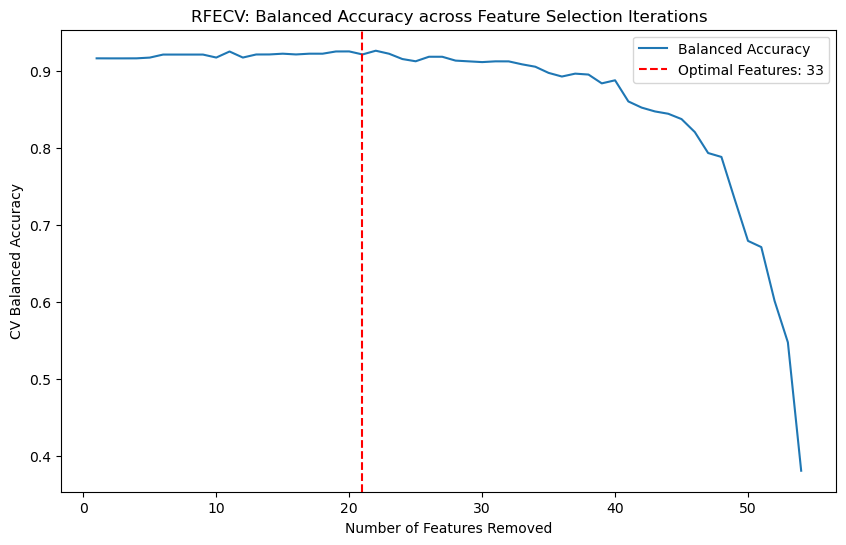

Optimal Feature Set:
Index(['daytime_encoded', 'weather_encoded', 'source_direction_encoded',
       'microphone_encoded', 'channel_encoded', 'mfcc_3', 'mfcc_4', 'mfcc_5',
       'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'mfcc_13', 'band_2_dB', 'band_3_dB', 'band_4_dB', 'band_6_dB',
       'band_7_dB', 'band_9_dB', 'band_10_dB', 'band_11_dB', 'band_12_dB',
       'band_14_dB', 'band_16_dB', 'band_18_dB', 'band_19_dB', 'band_20_dB',
       'band_21_dB', 'band_22_dB', 'band_23_dB', 'peak_dB_2'],
      dtype='object')

Test Set Evaluation with Optimal Features:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        21
           1       0.99      1.00      1.00      1561
           2       0.99      0.97      0.98        86

    accuracy                           0.99      1668
   macro avg       0.97      0.91      0.94      1668
weighted avg       0.99      0.99      0.99      1668



In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# 1) Load + Filter the Dataset
# Filter out rows where vehicle_encoded == 3
df_filtered = df_vehicle_classification[df_vehicle_classification['vehicle_encoded'] != 3]

# Extract features and target
X = df_filtered.drop(
    columns=[
        'file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0',
        'date_time_encoded', 'location_encoded', 'speed_kmh_encoded'
    ]
)
y = df_filtered['vehicle_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# 2) Scale the Data (ONLY the audio features)
audio_features = [
    'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
    'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
    'band_1_dB', 'band_2_dB', 'band_3_dB', 'band_4_dB', 'band_5_dB', 'band_6_dB',
    'band_7_dB', 'band_8_dB', 'band_9_dB', 'band_10_dB', 'band_11_dB', 'band_12_dB',
    'band_13_dB', 'band_14_dB', 'band_15_dB', 'band_16_dB', 'band_17_dB', 'band_18_dB',
    'band_19_dB', 'band_20_dB', 'band_21_dB', 'band_22_dB', 'band_23_dB', 'band_24_dB',
    'band_25_dB', 'band_26_dB', 'band_27_dB', 'band_28_dB', 'band_29_dB',
    'peak_dB_1', 'peak_freq_1', 'peak_dB_2', 'peak_freq_2', 'peak_dB_3', 'peak_freq_3',
    'octband_dB_mean'
]

scaler = StandardScaler()

# Make copies so we don't overwrite original X_train/X_test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit/transform ONLY audio features
X_train_scaled[audio_features] = scaler.fit_transform(X_train[audio_features])
X_test_scaled[audio_features] = scaler.transform(X_test[audio_features])

# 3) Set up Logistic Regression
log_reg = LogisticRegression(
    solver='lbfgs', 
    max_iter=10000,   # Increased to avoid convergence warnings
    random_state=42
)

# 4) Feature Selection via RFECV
rfecv = RFECV(
    estimator=log_reg,
    step=1,
    cv=5,
    scoring='balanced_accuracy'
)
rfecv.fit(X_train_scaled, y_train)

# Identify the number of features removed at each iteration
features_removed = [
    X_train.shape[1] - n 
    for n in range(len(rfecv.cv_results_['mean_test_score']))
]

# Find the optimal number of features
optimal_num_features = X_train.shape[1] - rfecv.n_features_

# 5) Plot the RFECV Performance
plt.figure(figsize=(10, 6))
sns.lineplot(x=features_removed, y=rfecv.cv_results_['mean_test_score'], label="Balanced Accuracy")
plt.axvline(x=optimal_num_features, color='red', linestyle='--', 
            label=f"Optimal Features: {rfecv.n_features_}")
plt.xlabel("Number of Features Removed")
plt.ylabel("CV Balanced Accuracy")
plt.title("RFECV: Balanced Accuracy across Feature Selection Iterations")
plt.legend()
plt.show()

# 6) Evaluate on the Test Set
optimal_features = X_train.columns[rfecv.support_]
print("Optimal Feature Set:")
print(optimal_features)

# Transform the scaled X to keep only the selected features
X_train_optimal = rfecv.transform(X_train_scaled)
X_test_optimal = rfecv.transform(X_test_scaled)

# Retrain Logistic Regression on these optimal features
log_reg.fit(X_train_optimal, y_train)

# Predictions
y_pred_optimal = log_reg.predict(X_test_optimal)
print("\nTest Set Evaluation with Optimal Features:")
print(classification_report(y_test, y_pred_optimal))

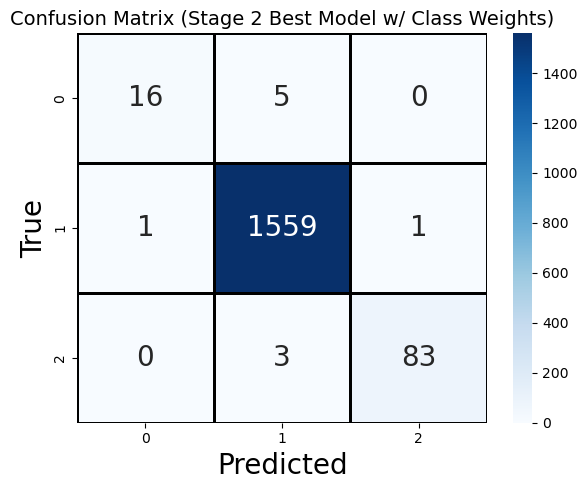

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)

# Create the plot
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap="Blues",
    linewidths=1,  # Adds line separators
    linecolor='black',  # Line color
    annot_kws={"size": 20}  # Increases font size for numbers
)

# Titles and labels
plt.title("Confusion Matrix (Stage 2 Best Model w/ Class Weights)", fontsize=14)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()

These are the final results.